In [24]:
import os
import sys

sys.path.append('..')
from pprint import pprint
import numpy as np
from dicomhd import io as dhd_io
from medpy.io import load as load_lbl
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


In [25]:
# patch size: [n_rows, n_cols, n_planes]
n_rows = 32
n_cols = 32
st = 2 # stride
th = 0.8

In [34]:
# path to data
path_train_img = '../../../data/gg/input/complete/'
path_train_lbl = '../../../data/gg/output/complete/'
out_path = '../data/tfrecods/'
# def unzip_dcm(path_to_data, path_to_write):
#     from zipfile import ZipFile
#     if not os.path.exists(os.path.join(path_to_write, 'unzip')):
#         os.mkdir(os.path.join(path_to_write,'unzip'))
#     path_to_write = os.path.join(path_to_write, 'unzip')
#     fname_zip = [f for f in os.listdir(path_to_data) if f[-4:] =='.zip']
#     for fname in fname_zip:
#         file = os.path.join(path_to_data,fname)
#         with ZipFile(file, 'r') as zip:
#             fname = fname.rsplit('.',1)[0]
#             os.mkdir(os.path.join(path_to_write, fname))
#             zip.extractall(os.path.join(path_to_write, fname))
#             print(f'extract {fname}')
# # uzip dcm files
# path_to_data = '../../../data/gg/output/'
# path_to_write = '../../../data/gg/output/'
# unzip_dcm(path_to_data, path_to_write)



# img_fname = 'groundglass-5ff7d9-Samir-2_reviewed_1-131'
# lbl_fname = 'groundglass-5ff7d9-Samir-2_reviewed_1-259'

In [36]:
with tf.device('/cpu:0'):
    
    store_as_tfrecord = True
    store_as_dataset = False
    
    

    
    img_fnames = sorted([f for f in os.listdir(path_test_img)])
    
    img_fnames.remove('.DS_Store')
    list_img_patches = []
    # get filename for labels
    lbl_fnames = sorted([f for f in os.listdir(path_test_lbl)])
    lbl_fnames.remove('.DS_Store')
    list_lbl_patches = []

        
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    if store_as_tfrecord:
        # create tfrecord writer instance
        writer = tf.io.TFRecordWriter(out_ffname)
    n_samples = 0
    for img_fname, lbl_fname in zip(img_fnames, lbl_fnames):
             
        print(img_fname, ',',lbl_fname)
        
        # extract lable patches
        lbl_file_path = os.path.join(path_test_lbl, lbl_fname)
        lbl_file_path = os.path.join(lbl_file_path, 'annotation.gipl')
        lbl, label_header = load_lbl(lbl_file_path)
        lbl = np.swapaxes(lbl,0,2)
        if lbl.sum() > 0:
            # get indices for voxels with ann
            idx_with_ann = np.ma.where(lbl.sum(axis=(1,2)) > 0)[0]
            # crop label
            lbl_ann = lbl[idx_with_ann, ...]
            print('label is:', lbl_ann.max())
#             tlbl_patches = extract_2D_patch(lbl_ann)
# #             break
#             # load image
#             img_file_path = os.path.join(path_test_img, img_fname)
#             img = dhd_io.read_series(img_file_path)
#             # crop image
#             img_ann=img.pixel_data[idx_with_ann, ...]
#             # extract image patches

            
          

NameError: name 'path_test_img' is not defined

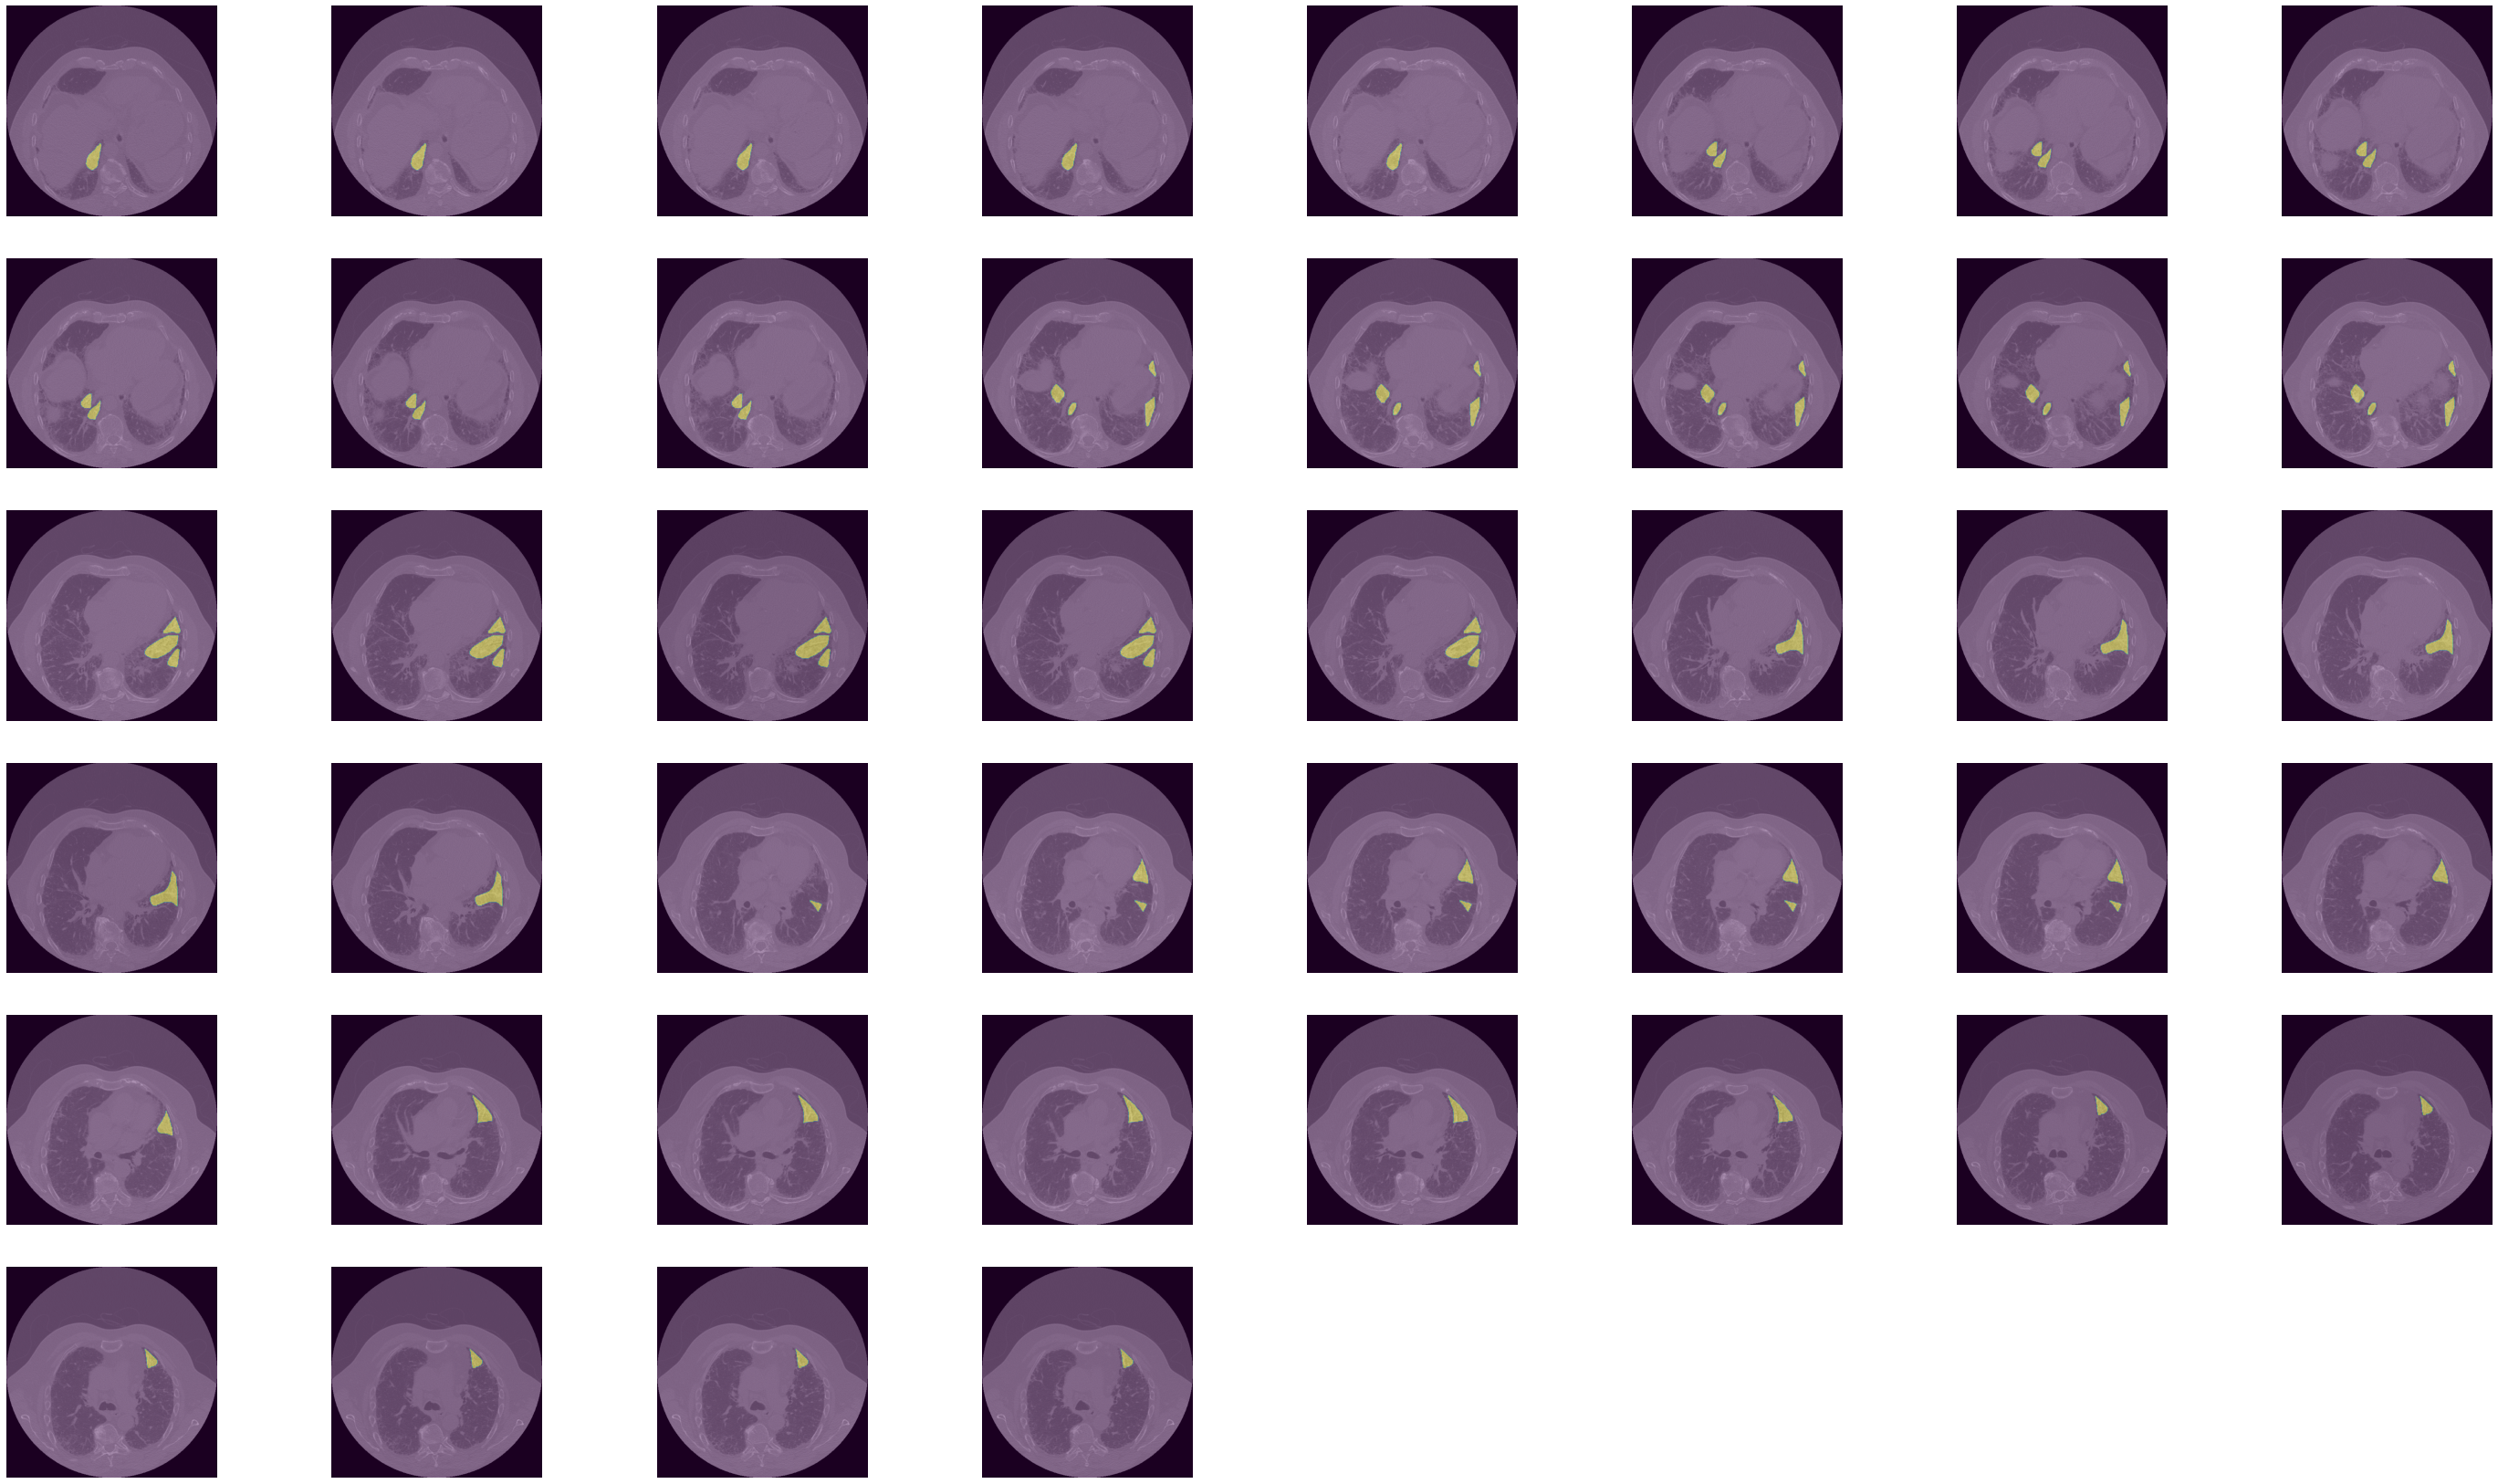

In [22]:
def show_batch(image_batch, lbl_batch):
    plt.figure(figsize=(50, 50))
    for n in range(image_batch.shape[0]):
        ax = plt.subplot(10, 8, n+1 )
        plt.imshow(image_batch[n], cmap='gray')
        plt.imshow(lbl_batch[n],alpha=0.4)
        plt.axis("off")
        
show_batch(img_ann, lbl_ann)

In [23]:
lbl_ann.max()

1

### Extract training patches

In [7]:
# extract patches
def extract_2D_patch(images, sizes=[1,n_rows, n_cols, 1], 
                     strides=[1, int(n_rows/st), int(n_cols/st), 1]):
    imgs = np.expand_dims(images, [-1])
    timgs = tf.convert_to_tensor(imgs, dtype='float32')
    print(timgs.shape)
    tpatches = tf.image.extract_patches(timgs, 
                         sizes=sizes,
                         strides=strides,
                         rates=[1, 1, 1, 1],
                         padding='SAME')
    img_patches = tf.reshape(tpatches, (-1,n_rows, n_cols, 1))
    print(img_patches.shape)
    return img_patches

def extract_2D_patch_labels(tlbl_patches, method='ratio', ratio_th=th):
    if method == 'max':
        t_patch_labels = tf.reduce_max(tlbl_patches, axis=[1,2,3])
    elif method == 'ratio':
        ratio_ann_voxels = tf.math.count_nonzero(tlbl_patches, axis=[1,2,3]) / (n_rows* n_cols)
        mask = ratio_ann_voxels < ratio_th
        t_patch_labels = tf.reduce_max(tlbl_patches, axis=[1,2,3])
        t_patch_labels = tf.where(mask, tf.zeros(tf.shape(t_patch_labels)), t_patch_labels)
    elif method == 'center':
        raise NotImplementedError
    else:
        raise ValueError('Invalid label extraction method!')
    
    return t_patch_labels


def extract_annotated_2D_patch(t_img_patches,t_lbl_patches):
    # get patch labels
    t_patch_labels = extract_2D_patch_labels(t_lbl_patches, 'ratio')
    mask = t_patch_labels > 0
    t_lbl_patches_with_annotation = tf.boolean_mask(t_lbl_patches, mask, axis=0)
    t_patch_img_with_annotation = tf.boolean_mask(t_img_patches, mask, axis=0)
    t_patch_lbl_with_annotation = tf.boolean_mask(t_patch_labels, mask, axis = 0)
    return t_patch_img_with_annotation, t_lbl_patches_with_annotation, t_patch_lbl_with_annotation


In [8]:
with tf.device('/cpu:0'):
    lbl_patches = extract_2D_patch(lbl_ann, sizes=[1,n_rows, n_cols, 1], 
                         strides=[1, int(n_rows/st), int(n_cols/st), 1])
    img_patches = extract_2D_patch(img_ann, sizes=[1,n_rows, n_cols, 1], 
                         strides=[1, int(n_rows/st), int(n_cols/st), 1])
# lbl_patches.shape
# img

(44, 512, 512, 1)
(45056, 32, 32, 1)
(44, 512, 512, 1)
(45056, 32, 32, 1)


In [9]:
with tf.device('/cpu:0'):
    t_patch_labels = extract_2D_patch_labels(lbl_patches, ratio_th=0.9)
    

In [10]:
with tf.device('/cpu:0'):
    t_patch_img_with_annotation, t_lbl_patches_with_annotation, t_patch_lbl_with_annotation=\
    extract_annotated_2D_patch(img_patches,lbl_patches)
t_patch_img_with_annotation.shape

TensorShape([40, 32, 32, 1])

1.0

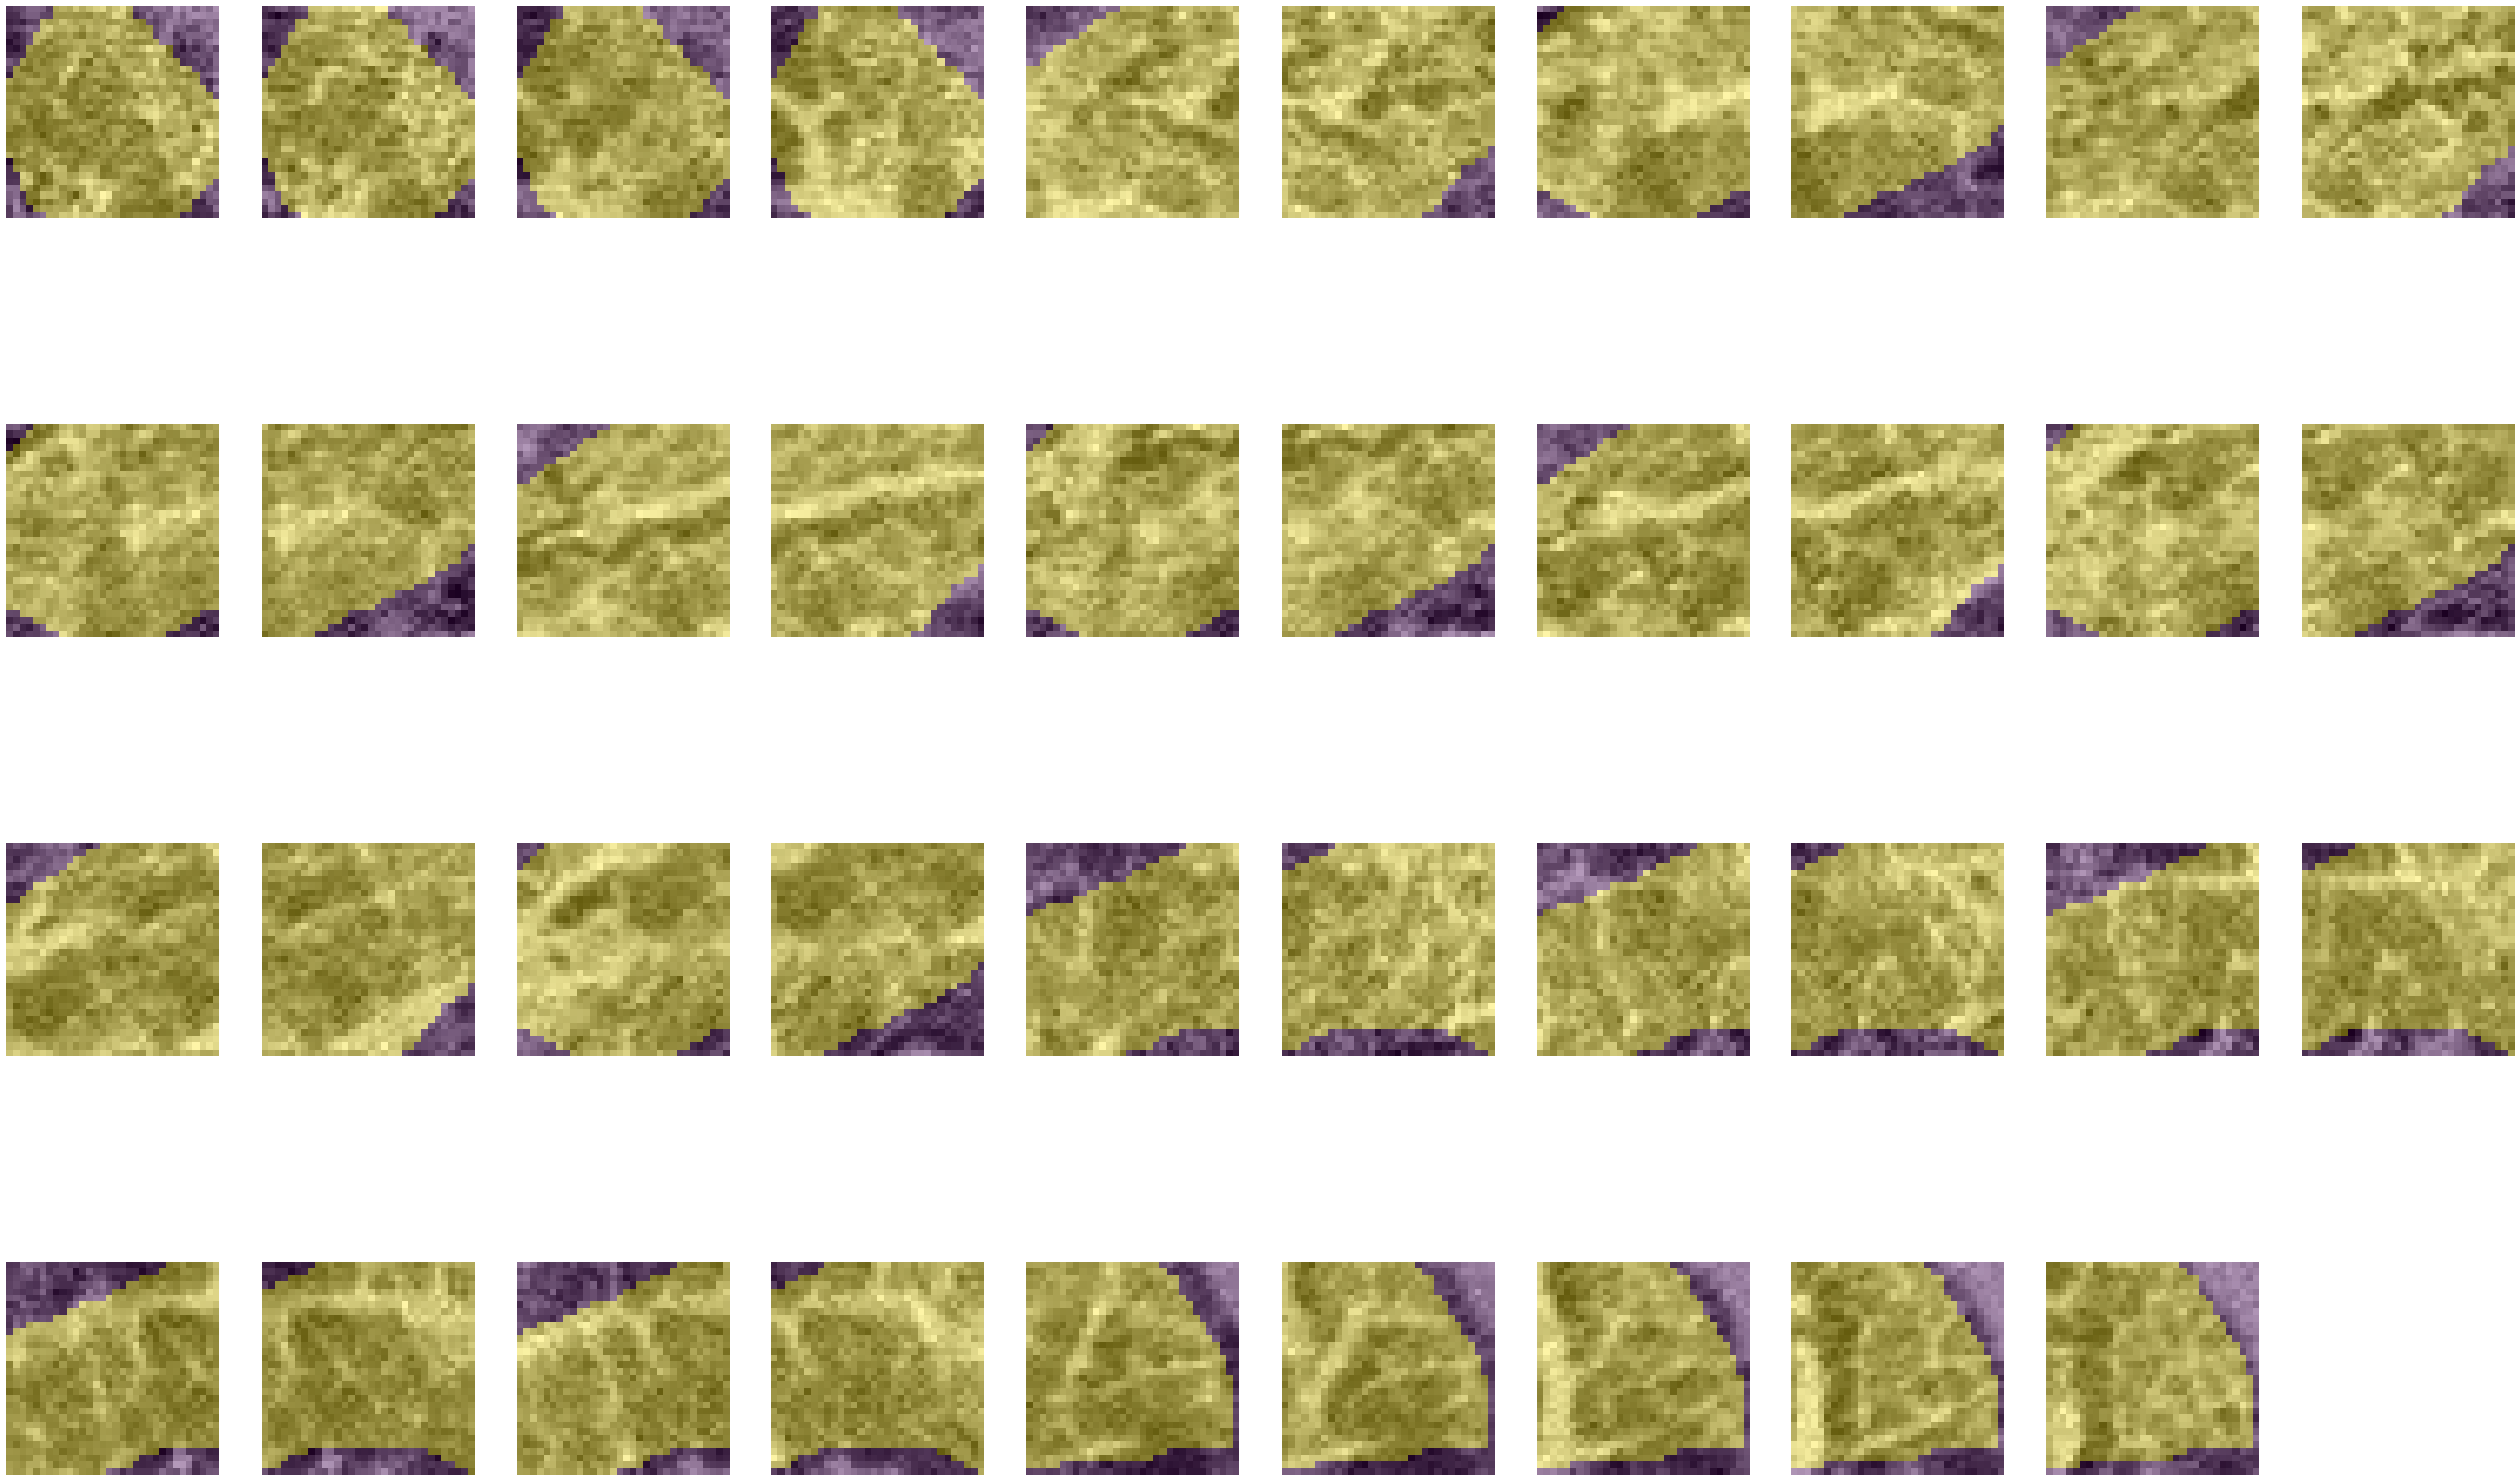

In [17]:
def show_tf_batch(image_batch, lbl_batch):
    plt.figure(figsize=(50, 50))
    for n in range(image_batch.shape[0]):
        ax = plt.subplot(6, 10, n+1 )
        plt.imshow(image_batch[n], cmap='gray')
#         print(image_batch[n].shape)
        plt.imshow(lbl_batch[n],alpha=0.4)
        plt.axis("off")
with tf.device('/cpu:0'):
    show_tf_batch(t_patch_img_with_annotation[1:50,...,0].numpy(),
              t_lbl_patches_with_annotation[1:50,...,0].numpy())
t_patch_lbl_with_annotation.numpy().max()